# Generate ERA5 forcing: own shapefile

This will consist of two parts in separate notebooks:
1. using a shapefile from Caravan
2. using your own shapefile!

ERA5 need 4 different inputs:
1. a shapefile
2. a time-window
3. a directory to save the data
4. and a type of forcing




## Using your own shapefile

If you have your own shapefile, skip the first part.
First I will guide your through making your own shapefile!

### Make your own shapefile

There are several ways to make shapefiles:
1. Make one using Arcgis.
2. Get the station.json from a GRDC station, which can be [converted](https://github.com/MarkMelotto/geojson_to_shapefile) into a shapefile or multiple if you have a bigger area.

You also need 5 different files:
1. .shp
2. .cpg
3. .prj
4. .dbf
5. .shx

We already have these files from the camels, but they are in a different directory now, for the purpose of this notebook

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

# Niceties
from rich import print

# General eWaterCycle
import ewatercycle
import ewatercycle.forcing

In [2]:
# The name of the shapefile
shape_file_name = "camelsgb_33039"  # river: Bedford Ouse at Roxton, England

# The time-window of the experiment
experiment_start_date = "2000-08-01T00:00:00Z"
experiment_end_date = "2005-08-31T00:00:00Z"

# The path save directory of the ERA5 data
forcing_path_ERA5 = Path.home() / "forcing" / shape_file_name / "ERA5" / "own_shapefile"
forcing_path_ERA5.mkdir(exist_ok=True)

Now we just point to where the shapefiles are, but to the .shp file specifically.

In [3]:
# The path to the shapefiles
shapefile_path =  Path.home() / "getting-started/book/some_content/forcing/shapefiles" / f"{shape_file_name}.shp"  # check this directory yourself!

## ERA5 Forcing Generation

Now that we have the shapefile we can almost get the ERA5 forcing.
But first we need to define a new path.
And we need to pick what kind of forcing we want to generate, this depends on what model you want to use, currently these sources are supported:
1. LumpedMakkinkForcing
2. DistributedMakkinkForcing
3. DistributedUserForcing
4. GenericDistributedForcing
5. GenericLumpedForcing
6. HypeForcing
7. LisfloodForcing
8. LumpedUserForcing
9. MarrmotForcing
10. PCRGlobWBForcing
11. WflowForcing

More details can be found in the [documentation](https://ewatercycle.readthedocs.io/en/latest/user_guide/02_forcing.html). And also in the [models section](https://www.ewatercycle.org/getting-started/main/some_content/different_models.html).

For now we will use 'lumped Makkink forcing', this is needed for running an HBV model.

In [4]:
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset="ERA5",
   start_time=experiment_start_date,
   end_time=experiment_end_date,
   shape=shapefile_path,
   directory=forcing_path_ERA5,
)

In [5]:
print(ERA5_forcing)

LumpedMakkinkForcing(
    start_time='2000-08-01T00:00:00Z',
    end_time='2005-08-31T00:00:00Z',
    directory=PosixPath('/home/mmelotto/forcing/camelsgb_33039/ERA5/own_shapefile/work/diagnostic/script'),
    shape=PosixPath('/home/mmelotto/getting-started/book/some_content/forcing/shapefiles/camelsgb_33039.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_2000-2005.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_2000-2005.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_2000-2005.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

So the LumpedMakkinkForcing stores the following:
1. pr: precipitation
2. tas: temperature
3. rsds: incoming shortwave radiation
4. evspsblpot: potential evaporation (note that this is calculated, using Makkink)

We can also load the forcing data after we have generated it:

In [6]:
load_location = forcing_path_ERA5 / "work" / "diagnostic" / "script"  # this is needed because the data is stored in a sub-directory
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

In [7]:
print(ERA5_forcing)

LumpedMakkinkForcing(
    start_time='2000-08-01T00:00:00Z',
    end_time='2005-08-31T00:00:00Z',
    directory=PosixPath('/home/mmelotto/forcing/camelsgb_33039/ERA5/own_shapefile/work/diagnostic/script'),
    shape=PosixPath('/home/mmelotto/forcing/camelsgb_33039/ERA5/own_shapefile/work/diagnostic/script/camelsgb_33039
.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_2000-2005.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_2000-2005.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_2000-2005.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

## The data

We can easily plot the data now!

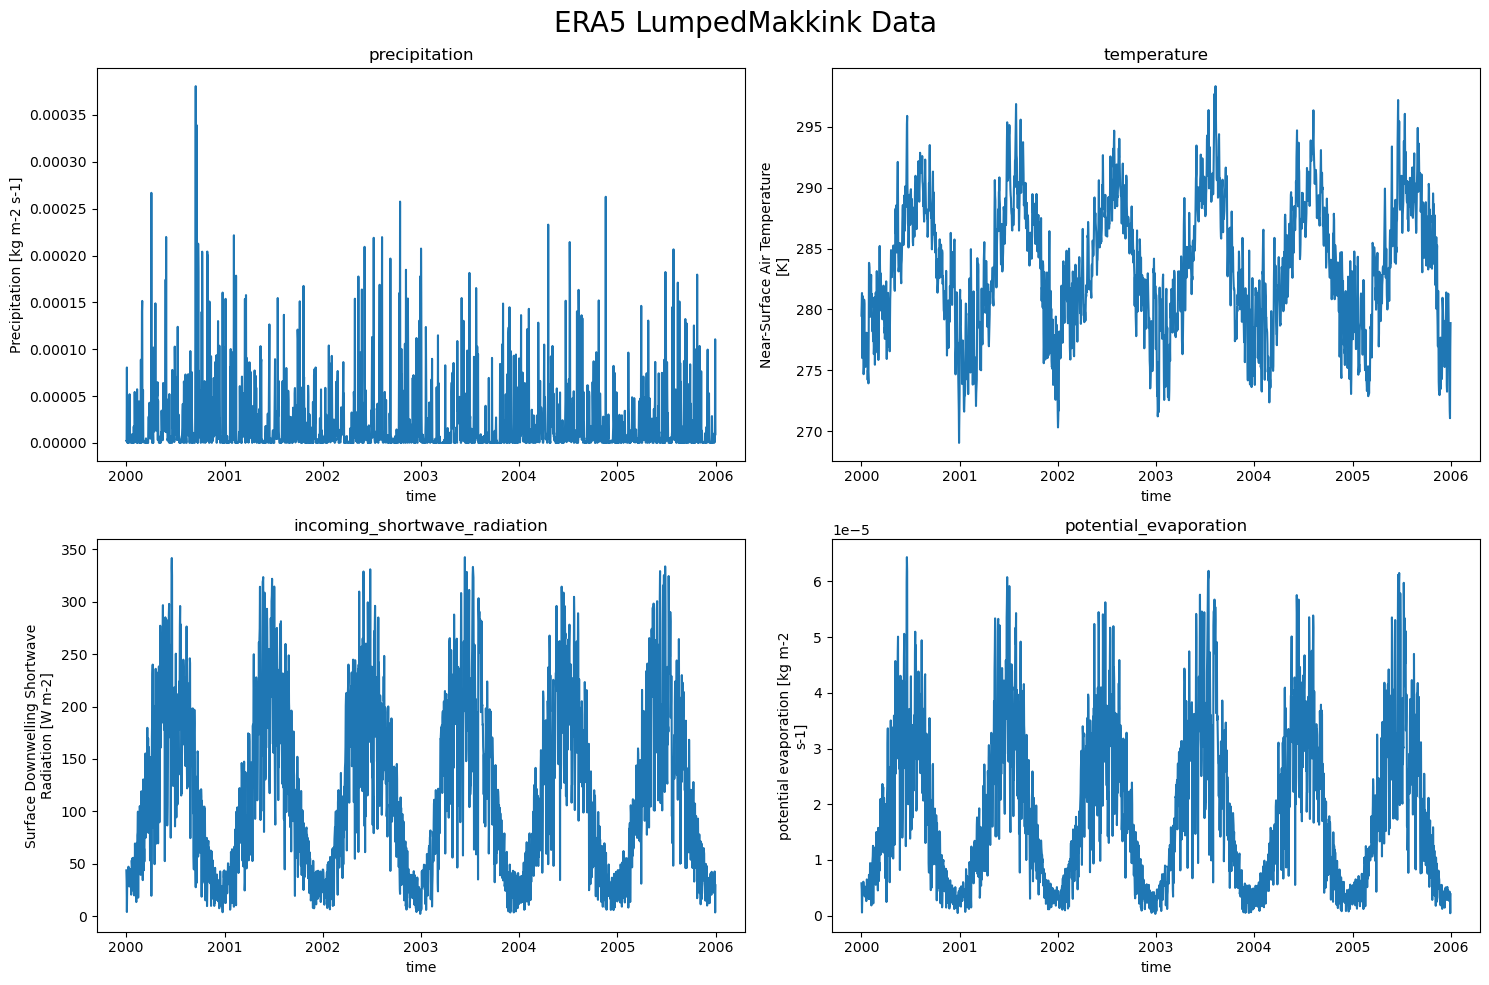

In [8]:
ERA5_data = {'precipitation pr': xr.open_dataset(ERA5_forcing['pr']),
             'temperature tas': xr.open_dataset(ERA5_forcing['tas']),
             'incoming_shortwave_radiation rsds': xr.open_dataset(ERA5_forcing['rsds']),
             'potential_evaporation evspsblpot': xr.open_dataset(ERA5_forcing['evspsblpot'])
}

plot_counter = 1
plt.figure(figsize=(15, 10))
for name, data in ERA5_data.items():
    plt.subplot(2,2, plot_counter)
    data[name.split(" ")[-1]].plot()
    plt.title(f"{name.split(" ")[0]}")
    plot_counter += 1

plt.suptitle("ERA5 LumpedMakkink Data", fontsize=20)
plt.tight_layout()